In [10]:
import os
import pandas as pd
import numpy as np
from pipeline import ClusterFeatures,LBP_3D

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,roc_auc_score



In [11]:

def XGBoost(X_tr, Y_tr, X_te, Y_te,quick=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    # Create the model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        random_state=42
    )

    if quick:
            best_model = xgb_model
            best_model.fit(X_tr, Y_tr)

            xgb_pred = best_model.predict(X_te)


            ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

            print("Classification Report: XGBoost",roc_auc_score(Y_te,xgb_pred))
            report = classification_report(Y_te, xgb_pred, digits=2)
            print(report)
            return best_model


    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',  
        cv=10,  
        verbose=1,
        n_jobs=-1  
    )

  
    grid_search.fit(X_tr, Y_tr)

   
    best_model = grid_search.best_estimator_
    best_model.fit(X_tr, Y_tr)

    xgb_pred = best_model.predict(X_te)

    ConfusionMatrixDisplay.from_estimator(estimator=best_model, X=X_te, y=Y_te)

    print("Classification Report: XGBoost",roc_auc_score(Y_te,xgb_pred))
    report = classification_report(Y_te, xgb_pred, digits=2)
    print(report)
    return best_model
def RF(X_tr, Y_tr, X_te, Y_te):

    param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=100, num=10)],  
        'max_depth': range(1, 20),  
        'criterion': ['gini', 'entropy'] 
    }


    optimal_params = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=10, 
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )


    optimal_params.fit(X_tr, Y_tr)
    print("Best parameters found: ", optimal_params.best_params_)


    criterion = optimal_params.best_params_['criterion']
    max_depth = optimal_params.best_params_['max_depth']
    n_estimators = optimal_params.best_params_['n_estimators']


    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        random_state=42
    )

    rf_model.fit(X_tr, Y_tr)


    rf_pred = rf_model.predict(X_te)


    ConfusionMatrixDisplay.from_estimator(estimator=rf_model, X=X_te, y=Y_te)

    print("Best Cross-Validation Score:",optimal_params.best_score_)
    print("Classification Report: Random Forest")
    print(classification_report(Y_te, rf_pred, digits=2),roc_auc_score(Y_te,rf_pred))
    return rf_model


In [12]:

csv_dir = '../Datasets/Rat PA Study/CSV/'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])

d7=[]
d14=[]
d21=[]

for d in dataframes:
    if 'PA7' in d[1]:
        d7.append(d)
    
    if 'PA14' in d[1]:
        d14.append(d)
    
    if 'PA21' in d[1]:
        d21.append(d)
    


print(len(d7),len(d14),len(d21))

12 18 22


In [13]:
data=[]
for d,p in d21:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])


lbp=LBP_3D(data)
features=lbp.extract()

In [14]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.67      0.57         3

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5



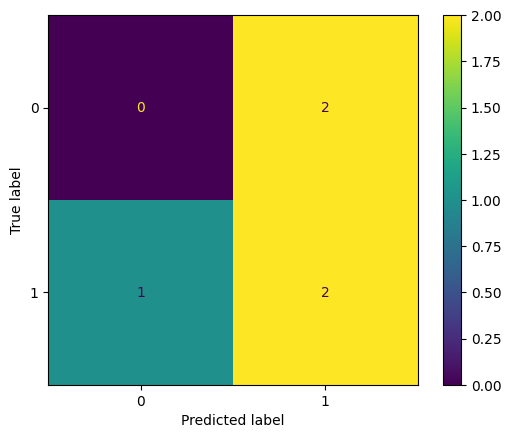

In [15]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)

In [16]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

In [17]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.75
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



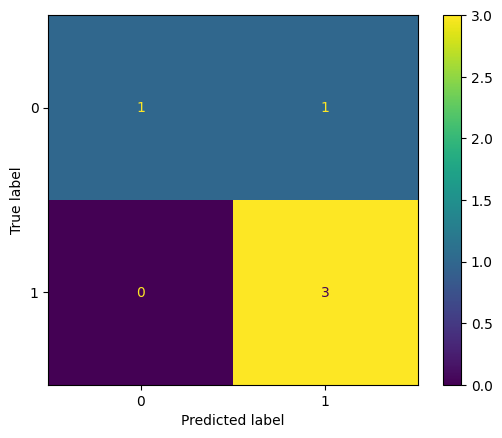

In [18]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)

In [19]:
data=[]
for d,p in d14:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])


lbp=LBP_3D(data)
features=lbp.extract()

In [20]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

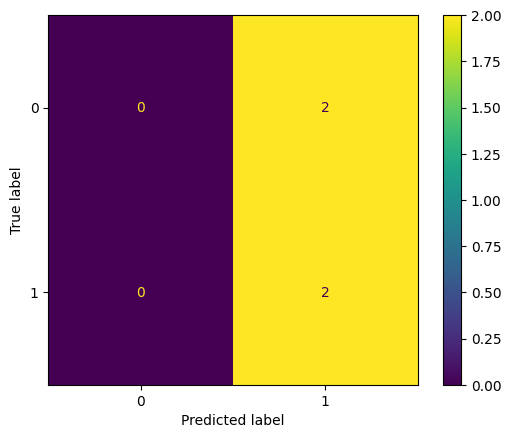

In [21]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)

In [22]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

In [23]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.75
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



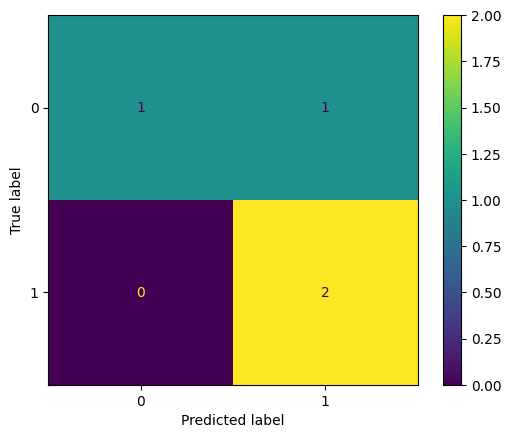

In [24]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)

In [25]:
data=[]
for d,p in d7:
    name=p.split('_XV')[0]+'_XV'
    name=name.split('/')[-1]
    d.columns=['SV','X','Y','Z']
    if 'WT' in p:
        
        data.append([d,0])
    else:
        data.append([d,1])


lbp=LBP_3D(data)
features=lbp.extract()

In [26]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

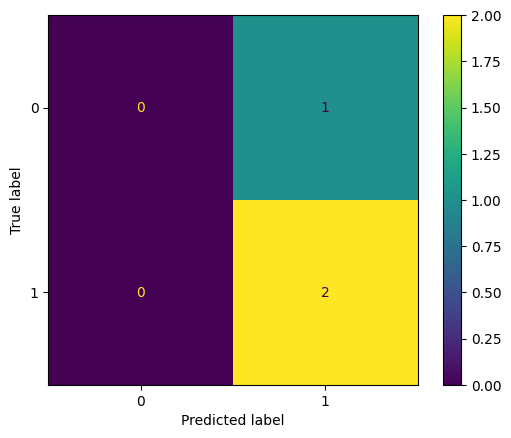

In [27]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

modelLBP=XGBoost(X_train,y_train,X_test,y_test,True)

In [28]:

c=ClusterFeatures(data)
features=c.extract()

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but K

In [29]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

Classification Report: XGBoost 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

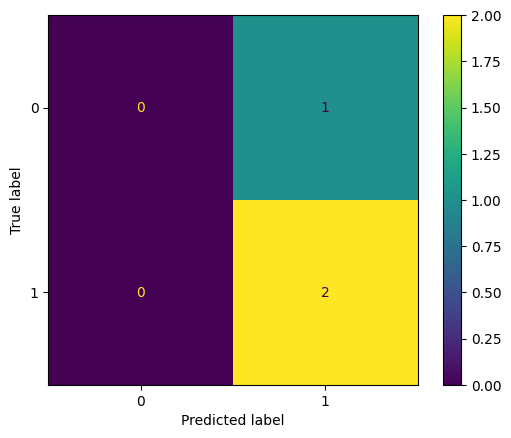

In [30]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)

model=XGBoost(X_train,y_train,X_test,y_test,True)